# Mouse brain dataset analysis

In [17]:
import pandas as pd
import numpy as np
import scanpy as sc
import anndata as ad
import scipy.io
import matplotlib.pyplot as plt
import os
from matplotlib.colors import ListedColormap, TwoSlopeNorm
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append(r'/import/home2/share/yqzeng/MacSGP/codes')
import MacSGP
from MacSGP.vis import plot_spatial_ct

/home/yzengbj/anaconda3/envs/factor/lib/python3.11/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(


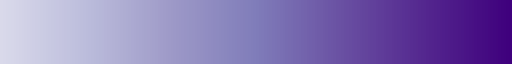

In [2]:
import matplotlib as mpl
from matplotlib import cm
mpl.rcParams.update({
    "pdf.fonttype": 42,          
    "ps.fonttype": 42,
    "axes.linewidth": 0.8,
})

mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 0.8,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

import seaborn as sns
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent
from matplotlib.colors import ListedColormap, TwoSlopeNorm

cmap_proportion = set_zero_in_cmap_to_transparent(cmap=sns.color_palette("Purples", as_cmap=True))
colors=cmap_proportion(np.arange(cmap_proportion.N))
colors = colors[cmap_proportion.N*1//4:cmap_proportion.N*4//4]
cmap_proportion = ListedColormap(colors)
cmap_proportion

In [3]:
RAW_PATH = "/home/yzengbj/my_project/data/Mouth_brain_visium"
DATA_PATH = "/home/yzengbj/factor/data/Mouth_brain_visium" 
SAVE_PATH = "/home/yzengbj/factor/results/Mouth_brain_visium" 
os.makedirs(os.path.join(DATA_PATH), exist_ok = True)
os.makedirs(os.path.join(SAVE_PATH), exist_ok = True)

## Benchmarking on Ext_Thal_1

In [ ]:
adata_1 = sc.read_h5ad(os.path.join(SAVE_PATH, "adata_result_visium_1.h5ad"))
adata_2 = sc.read_h5ad(os.path.join(SAVE_PATH, "adata_result_visium_2.h5ad"))

# adata_1.obsm['spatial'][:,1] = - adata_1.obsm['spatial'][:,1]
# adata_2.obsm['spatial'][:,1] = - adata_2.obsm['spatial'][:,1]

In [9]:
factor_df_1 = adata_1.obsm['factor'].copy()
factor_df_2 = adata_2.obsm['factor'].copy()

ct = 'Ext_Thal_1'  # Cell type of interest
BENCHMARK_PATH  = '/import/home2/share/yqzeng/MacSGP/results/Mouth_brain_visium'
methods = ['nmf', 'mofa', 'spicemix', 'stamp']
factors = []
loadings = []
for method in methods:
    factor_i = pd.read_csv(os.path.join(BENCHMARK_PATH, method, 'visium_1', 'factors.csv'), index_col=0)
    factors.append(factor_i)
    loading_i = pd.read_csv(os.path.join(BENCHMARK_PATH, method, 'visium_1', 'loadings.csv'), index_col=0)
    loadings.append(loading_i)

# nmf: 4, spicemix: 5, mofa: 3, stamp: 7

factor_ct = np.concatenate([adata_1.obsm['proportion'][ct].values.reshape(-1, 1),
                            factors[0].iloc[:, 3].values.reshape(-1, 1), 
                            factors[1].iloc[:, 2].values.reshape(-1, 1), 
                            factors[2].iloc[:, 5].values.reshape(-1, 1), 
                            factors[3].iloc[:, 5].values.reshape(-1, 1),
                            factor_df_1[ct].values.reshape(-1, 1)], axis=1)

methods = ['Ext_Thal_1', 'NMF', 'MOFA', 'SpiceMix', 'STAMP', 'MacSGP']
factor_ct_df = pd.DataFrame(factor_ct, index=adata_1.obs_names, columns=methods)

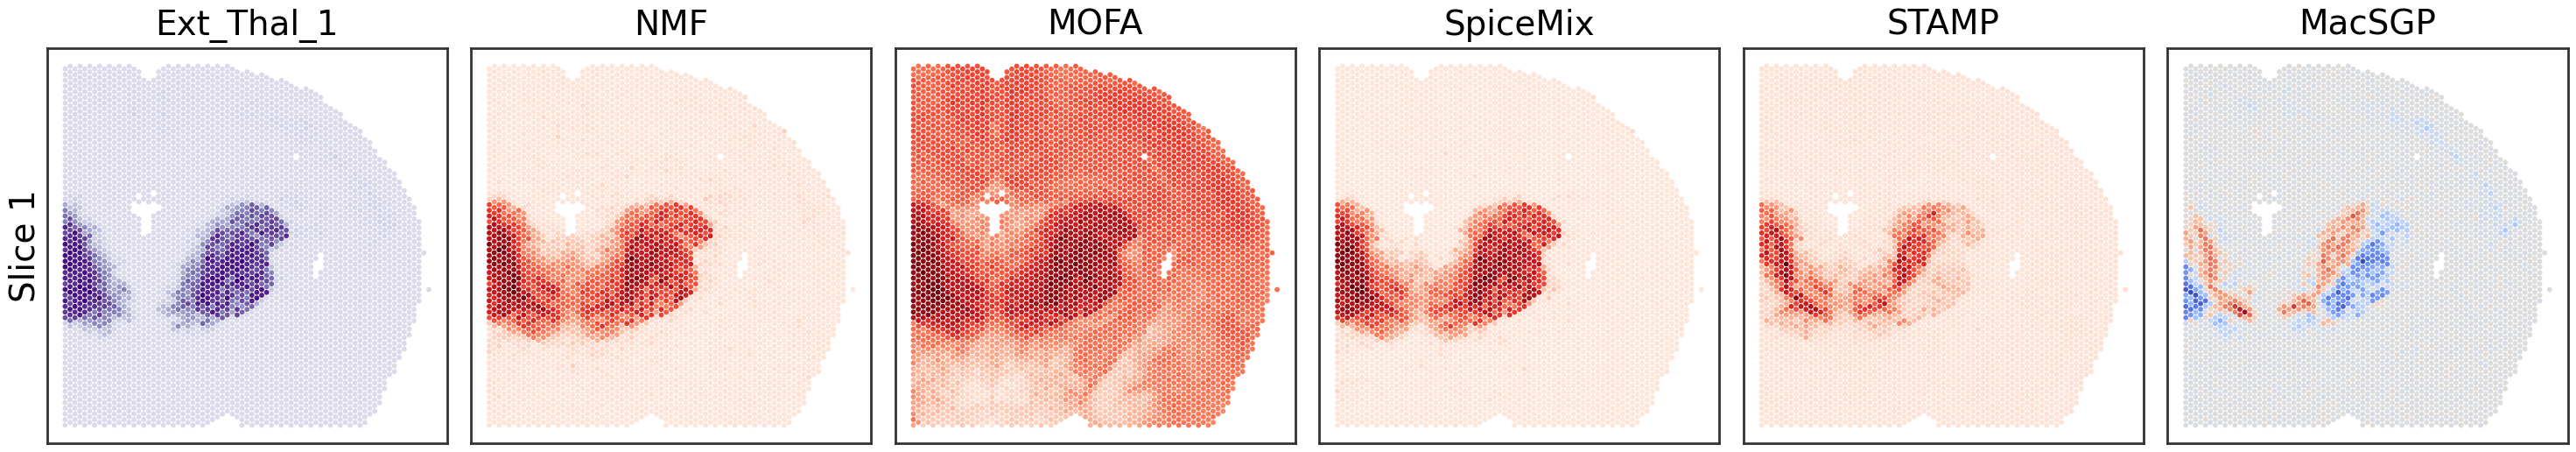

In [13]:
def clipped_cmap(base_cmap='Reds', cut=0.2):
    base = plt.get_cmap(base_cmap)
    colors = base(np.linspace(cut, 1.0, 256))
    return mpl.colors.ListedColormap(colors)

cmap = clipped_cmap('Reds', cut=0.1) 

n_methods = len(methods)
nrows, ncols = 1, 6

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 6))
cmap = cmap
spot_plot = factor_ct_df['Ext_Thal_1'] > 0.1

for i, ax in enumerate(axes.flat[:n_methods]):
    method_i = methods[i]
    data = factor_ct_df[method_i].to_numpy()
    cmap_i = cmap
    if method_i == 'MacSGP':
        cmap_i='coolwarm'
    #norm_i = mpl.colors.TwoSlopeNorm(vcenter=0.0)

    sca = ax.scatter(
        adata_1.obsm["spatial"][:, 0],
        adata_1.obsm["spatial"][:, 1],
        c=data,
        s=10,
        cmap=cmap_i if method_i != 'Ext_Thal_1' else cmap_proportion,
        #norm=norm_i
    )
    ax.set_title(method_i, fontsize=28, y =1.015)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)

axes[0].set_ylabel('Slice 1', fontsize=28)

fig.subplots_adjust(left=0.03, right=0.99, top=0.96, bottom=0.04,
                    wspace=0.06, hspace=0.05)
#plt.savefig(os.path.join(FIG_PATH, "mouse_brain_visium1_comparision.pdf"), dpi=100)
plt.show()

In [22]:
ct = 'Ext_Thal_1'
loading_ct_1 = adata_1.varm['loading'][ct]
loading_ct_2 = adata_2.varm['loading'][ct]
BENCHMARK_PATH = '/import/home2/share/yqzeng/MacSGP/results/Mouth_brain_visium'
methods = ['nmf', 'mofa', 'spicemix', 'stamp']
factors = []
loadings = []
for method in methods:
    loading_i = pd.read_csv(os.path.join(BENCHMARK_PATH, method, 'visium_1', 'loadings.csv'), index_col=0)
    loadings.append(loading_i)
loadings.append(loading_ct_1)

# nmf: 4, spicemix: 5, mofa: 3, stamp: 7,6
loading_ct = np.concatenate([loadings[0].iloc[:, 3].values.reshape(1, -1), 
                             loadings[1].iloc[:, 2].values.reshape(1, -1), 
                             loadings[2].iloc[:, 5].values.reshape(1, -1),
                             loading_ct_1.values.reshape(1, -1)
                             ], axis=0)
methods = ['NMF', 'MOFA', 'SpiceMix', 'MacSGP']
loading_ct_df = pd.DataFrame(loading_ct.T, index=adata_1.var_names, columns=methods)

In [24]:
gene_highlighted = ['Pcp4', 'Prkcd','Adcy1', 'Cplx1','Cck',  #marker
                    'Stum', 'Scn2a', 'Plxnc1','Rasgef1b', 'Opcml',
                    'Eps8l2','Nefm', 'Prmt8', 'Scn1b', 'Gabra1'
                    ]

In [25]:
loading_ct_stamp_normalized = np.exp(loadings[3].iloc[:, 5]) / np.sum(np.exp(loadings[3].iloc[:, 6]))
loading_ct_stamp_normalized_highlighted = pd.Series(0, index=gene_highlighted)

for gene in gene_highlighted:
    if gene in loading_ct_stamp_normalized.index:
        loading_ct_stamp_normalized_highlighted[gene] = loading_ct_stamp_normalized[gene]

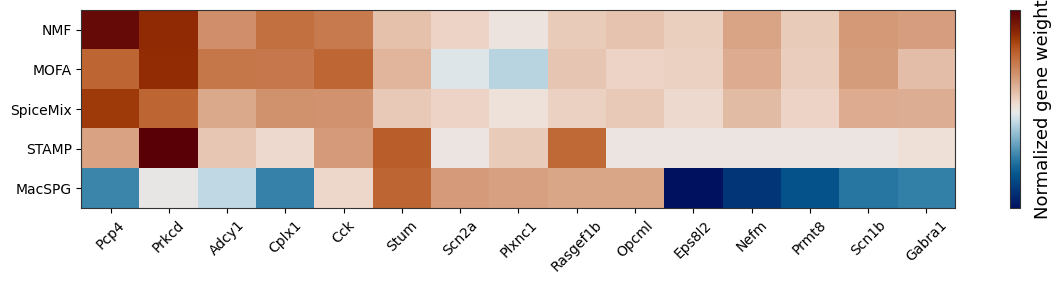

In [26]:
# heatmap of signature genes
from cmcrameri import cm
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm

loading_ct_df_normalized = loading_ct_df.div(loading_ct_df.abs().sum(axis=0), axis=1)
loading_ct_df_highlight = loading_ct_df_normalized.loc[gene_highlighted, :].copy()
loading_ct_df_highlight['STAMP'] = loading_ct_stamp_normalized_highlighted
loading_ct_df_highlight = loading_ct_df_highlight[['NMF', 'MOFA', 'SpiceMix', 'STAMP', 'MacSGP']]

plt.figure(figsize=(12, 3))
im = plt.imshow(
    loading_ct_df_highlight.T,
    cmap=cm.vik, aspect='auto',
    norm=TwoSlopeNorm(vcenter=0, vmax=0.005)
)

# 添加 colorbar，并设置标题（标签）
cbar = plt.colorbar(im)
cbar.set_label('Normalized gene weight', rotation=90, labelpad=10)  # 竖直色条，转90度；labelpad调整与色条距离
# 可选：去掉刻度（如仍想无刻度）
cbar.set_ticks([])

plt.xticks(range(len(gene_highlighted)), gene_highlighted, rotation=45)
plt.yticks(range(5), ['NMF', 'MOFA', 'SpiceMix', 'STAMP', 'MacSPG'])

plt.tight_layout()
#plt.savefig(os.path.join(FIG_PATH, "mouse_brain_loading_heatmap.pdf"), dpi=100)
plt.show()

## MMM ct-svg results

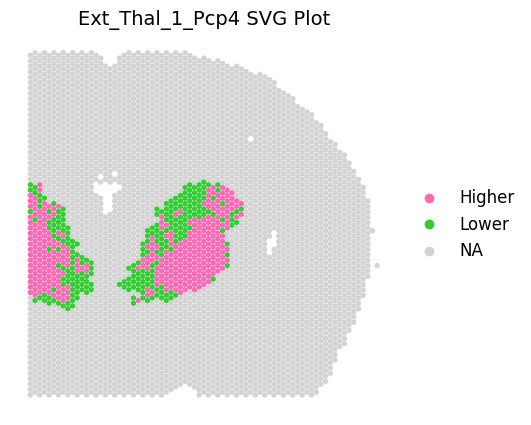

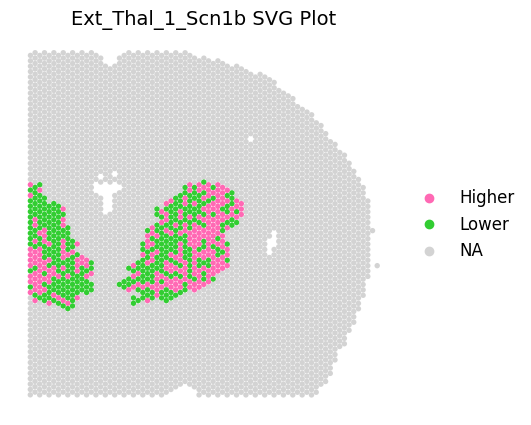

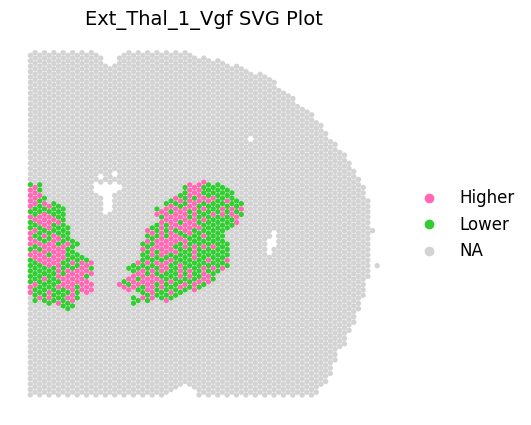

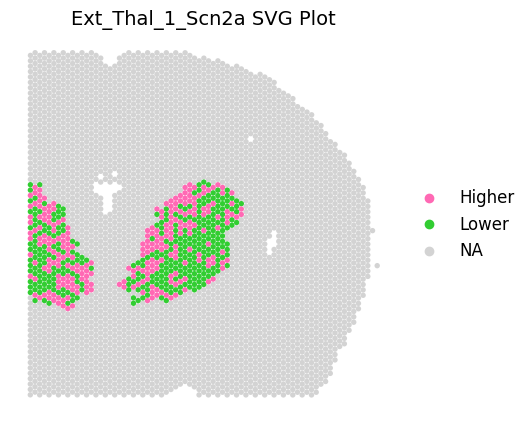

In [21]:
SVG_PATH = "/import/home2/share/yqzeng/MacSGP/data/Mouth_brain_visium/visium_1/svg_data"

ct = 'Ext_Thal_1'
svg_list = ['Pcp4', 'Scn1b', 'Vgf', 'Scn2a']
adata_1.obsm['spatial'][:,1] = - adata_1.obsm['spatial'][:,1]
for gene in svg_list:
    pair = f"{ct}_{gene}"
    rel_expr_level = pd.read_csv(os.path.join(SVG_PATH, f"{pair}_rel_expr_level_.csv"), index_col=0)
    spot_name = [s.split('-slice0')[0] for s in rel_expr_level.index.tolist()]
    adata_1.obs['tmp'] = np.nan
    adata_1.obs.loc[spot_name, 'tmp'] = rel_expr_level['rel_expr_level'].values


    nrows, ncols = 1, 1
    fig, axes = plt.subplots(nrows, ncols, figsize=(5 * ncols, 5 * nrows))
    sc.pl.spatial(
        adata_1,
        color='tmp',
        #cmap=cmap,
        palette=["#FF69B4", "#32CD32"],
        na_color=None,
        spot_size=100,
        colorbar_loc=None,  # 禁用每个图的 colorbar
        title=f"{pair} SVG Plot",
        frameon=False,
        ax=axes,  # 指定当前 ax
        show=False,  
        img_key=None
    )
    plt.show()

## Replicability analysis

In [27]:
ct_plot = ['Ext_Hpc_CA1', 'Ext_Hpc_DG1', 'Ext_L5_2', 'Ext_Amy_2', 'Ext_Thal_2', 'Ext_Med']
loading_df_1 = adata_1.varm['loading'].copy()
loading_df_2 = adata_2.varm['loading'].copy()
cor = loading_df_1[ct_plot].corrwith(loading_df_2[ct_plot])

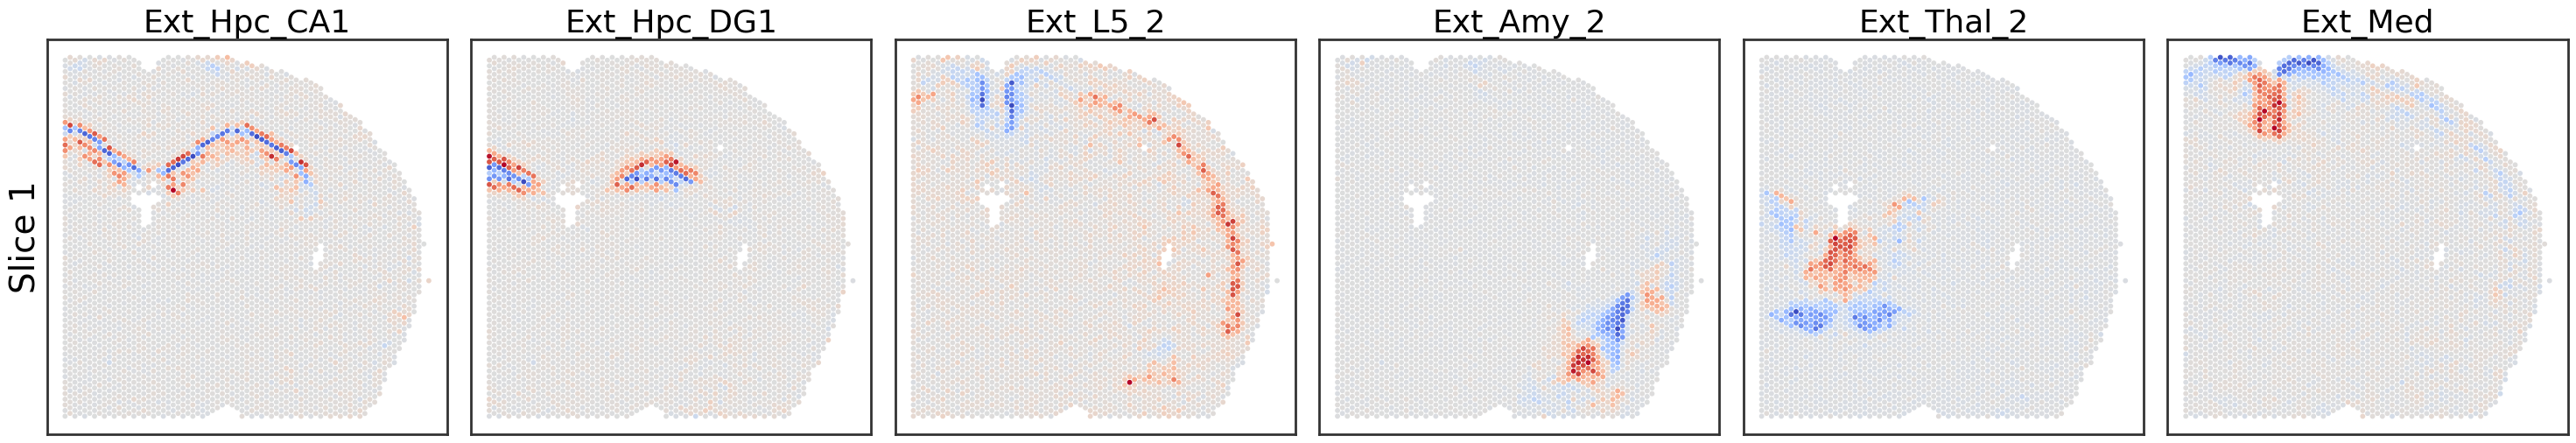

In [29]:
n_celltypes = len(ct_plot)
nrows, ncols = 1, 6

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 6))
cmap = 'coolwarm'

for i, ax in enumerate(axes.flat[:n_celltypes]):
    ct = ct_plot[i]
    data = factor_df_1[ct].to_numpy()

    norm_i = mpl.colors.TwoSlopeNorm(vcenter=0.0)

    sca = ax.scatter(
        adata_1.obsm["spatial"][:, 0],
        -adata_1.obsm["spatial"][:, 1],
        c=data,
        s=10,
        cmap=cmap,
        norm=norm_i
    )
    ax.set_title(ct, fontsize=26)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)

axes[0].set_ylabel('Slice 1', fontsize=28)

fig.subplots_adjust(left=0.03, right=0.99, top=0.96, bottom=0.04,
                    wspace=0.06, hspace=0.05)
#plt.savefig(os.path.join(FIG_PATH, "mouse_brain_visium1.pdf"), dpi=100)
plt.show()

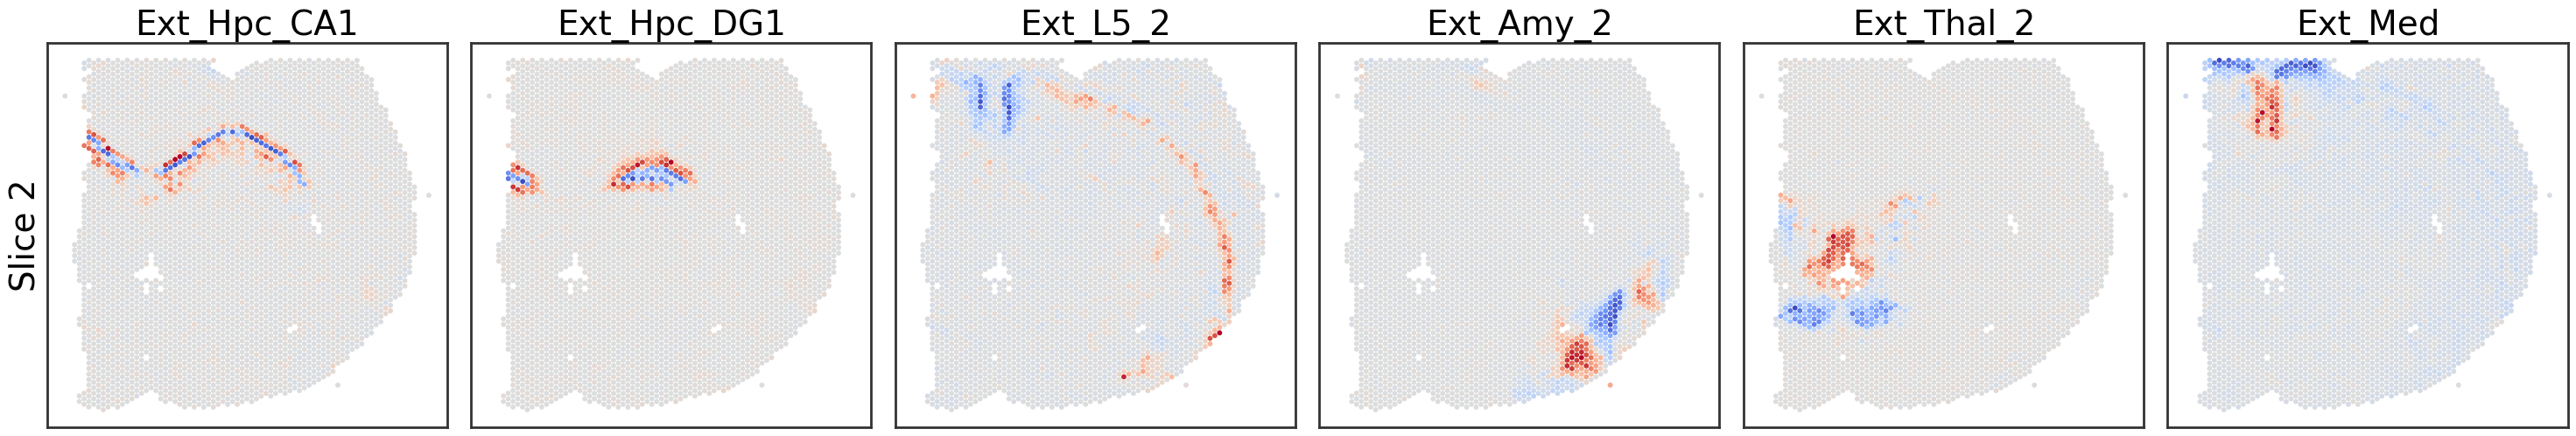

In [30]:
n_celltypes = len(ct_plot)
nrows, ncols = 1, 6

fig, axes = plt.subplots(nrows, ncols, figsize=(30, 6))
cmap = 'coolwarm'

for i, ax in enumerate(axes.flat[:n_celltypes]):
    ct = ct_plot[i]
    data = factor_df_2[ct].to_numpy()
    if ct in ['Ext_Amy_2', 'Ext_Med']:
        data = -data
    norm_i = mpl.colors.TwoSlopeNorm(vcenter=0.0)

    sca = ax.scatter(
        adata_2.obsm["spatial"][:, 0],
        adata_2.obsm["spatial"][:, 1],
        c=data,
        s=10,
        cmap=cmap,
        norm=norm_i
    )
    ax.set_title(ct, fontsize=28)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_aspect('equal', adjustable='box')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['right'].set_linewidth(2)
    ax.spines['top'].set_linewidth(2)

axes[0].set_ylabel('Slice 2', fontsize=28)

fig.subplots_adjust(left=0.03, right=0.99, top=0.96, bottom=0.04,
                    wspace=0.06, hspace=0.05)
#plt.savefig(os.path.join(FIG_PATH, "mouse_brain_visium2.pdf"), dpi=100)
plt.show()

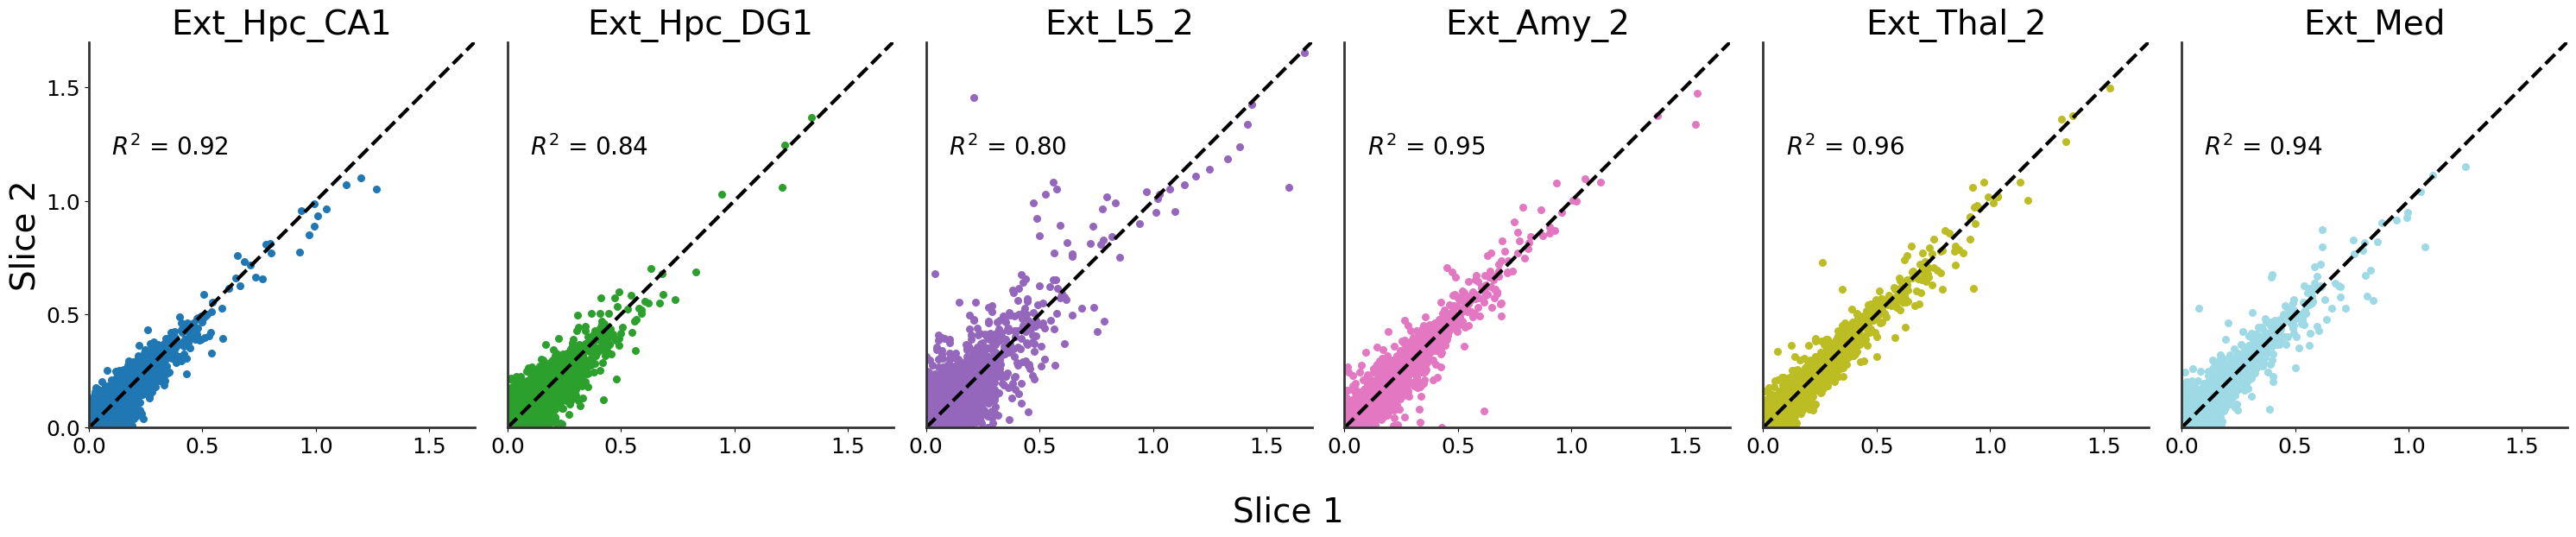

In [31]:
cmap = cm.vik.copy()
cmap.set_bad(color="#E6E6E6")

mpl.rcParams.update({
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.edgecolor": "#333333",
    "axes.linewidth": 0.8,
    "figure.facecolor": "white",
    "axes.facecolor": "white",
})

num_cts = len(ct_plot)
num_cols = 6
num_rows = 1
x_max = 1.7
y_max = 1.7
tick_fs = 18
color_list = plt.cm.get_cmap('tab20', num_cts)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(30, 6 * num_rows))
axes = np.ravel(axes)

ticks = np.array([0, 0.5, 1.0, 1.5])

for i, ct_i in enumerate(ct_plot[:6]):
    ax = axes[i]
    ax.scatter(
        np.abs(loading_df_1[ct_i] * np.sign(cor[ct_i])),
        np.abs(loading_df_2[ct_i]),
        s=30,
        color=color_list(i % num_cts)
    )
    r2 = np.corrcoef(loading_df_1[ct_i] * cor[ct_i], loading_df_2[ct_i])[0, 1] ** 2
    ax.text(0.1, 1.2, f'$R^2$ = {r2:.2f}', fontsize=20, color='black',
            )
    ax.set_title(f'{ct_i}', fontsize=28)
    ax.plot([0, x_max], [0, y_max], '--', lw=3, color='black')
    lim_max = max(x_max, y_max)
    ax.set_xlim(0, lim_max)
    ax.set_ylim(0, lim_max)
    ax.set_aspect('equal', adjustable='box')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.set_xticks(ticks)
    #ax.set_yticks(ticks)
    ax.tick_params(axis='x', labelbottom=True, labelsize=tick_fs)
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    #ax.tick_params(axis='y', labelsize=tick_fs)

axes[0].set_ylabel('Slice 2', fontsize=28)
axes[0].tick_params(axis='y', labelleft=True, labelsize=tick_fs)
axes[0].set_yticks(ticks)
for ax in axes[1:num_cts]:
    ax.set_yticks([])

fig.suptitle('Slice 1', fontsize=28, y=-0.05)
plt.tight_layout()
#plt.savefig(os.path.join(FIG_PATH, "mouse_brain_loading_scatter.pdf"), dpi=100)
plt.show()